In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import anndata 

import scanpy as sc
import os
import copy

EPS = 1e-3


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )



seurat_cluster_type = pd.read_csv('/home/syyang/adipose_arionas/seurat_cluster_label_2.csv')
adipose_sn_ad.obs = adipose_sn_ad.obs.reset_index().merge(seurat_cluster_type, left_on='seurat_clusters', right_on='seurat_clusters', how='left').set_index('index')

adipose_sn_ad.obs.loc[adipose_sn_ad.obs['mapped_cell_type'] == '?', 'mapped_cell_type'] = '0'  # set unknown to 0
adipose_sn_ad.obs['mapped_cell_type'] = adipose_sn_ad.obs['mapped_cell_type'].astype('category') 


adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')
adipose_sn_ad.obs['seurat_clusters'] = adipose_sn_ad.obs['seurat_clusters'].astype('category')

In [287]:
# load human lung disease dataset (scRNAseq)
sc_adata_file = '/home/syyang/GitRepo/cs294/finalproject/UCE_downloads/human_lung_disease.h5ad'
human_lung_disease = sc.read_h5ad(sc_adata_file)

healthy_human_lung = human_lung_disease[human_lung_disease.obs['Disease_Identity'] == 'Control']
# remove multiplets
healthy_human_lung = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] != 'Multiplet'] 
healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']
healthy_human_lung.shape

sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)

# Calculate the latent center for each celltype (using scRNAseq data)
celltypes = healthy_human_lung.obs['CellType_Category'].unique()
scRNAseq_celltype_latent_center = {}
scRNAseq_celltype_latent_var = {}
for type in celltypes:
    scRNAseq_celltype_latent_center[type] = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] == type].obsm['X_uce'].mean(axis=0)
    scRNAseq_celltype_latent_var[type] = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] == type].obsm['X_uce'].var(axis=0)
    
sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)
sc_latent_center_var = healthy_human_lung.obsm['X_uce'].var(axis=0)

/tmp/ipykernel_312769/1371390375.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']


In [292]:
print(f'cell_type categories:" {adipose_sn_ad.obs["mapped_cell_type"].cat.categories}')

cell_type_center_mean = torch.zeros((adipose_sn_ad.obs['mapped_cell_type'].cat.categories.nunique() , 1280))
for i, type in enumerate(adipose_sn_ad.obs['mapped_cell_type'].cat.categories):
    print(f"i = {i}, type = {type}")
    if type != '0':
        cell_type_center_mean[i] = torch.tensor(scRNAseq_celltype_latent_center[type])
    
    else:
        cell_type_center_mean[i] = torch.tensor(sc_latent_center)
        
        
cell_type_center_var = torch.zeros((adipose_sn_ad.obs['mapped_cell_type'].cat.categories.nunique() , 1280))
for i, type in enumerate(adipose_sn_ad.obs['mapped_cell_type'].cat.categories):
    if type != '0':
        cell_type_center_var[i] = torch.tensor(scRNAseq_celltype_latent_var[type])
    
    else:
        cell_type_center_var[i] = torch.tensor(sc_latent_center_var)

cell_type categories:" Index(['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'], dtype='object')
i = 0, type = 0
i = 1, type = Endothelial
i = 2, type = Epithelial
i = 3, type = Lymphoid
i = 4, type = Myeloid
i = 5, type = Stromal


In [5]:
# Construct anndata with center UCE latent space for visualization
cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:6, :].X, obs=adipose_sn_ad[:6, ].obs)
cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal']
cell_type_ad.obsm['X_uce'] = cell_type_center_mean

In [278]:
simulate_cell_type_centroid = torch.distributions.Normal(cell_type_center_mean,  0.01 * torch.ones_like(cell_type_center_mean) ).sample(torch.Size([200])).view(-1, 1280)

n_samples = simulate_cell_type_centroid.shape[0]

simulated_cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:n_samples, :].X, obs=adipose_sn_ad[:n_samples, ].obs)
simulated_cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'] * int(n_samples / 6)
simulated_cell_type_ad.obsm['X_uce'] = simulate_cell_type_centroid

In [53]:
dd = pd.DataFrame({'cat': adipose_sn_ad.obs['mapped_cell_type'].values, "level": adipose_sn_ad.obs['mapped_cell_type'].cat.codes})
dd.groupby(['level', 'cat']).size().unstack()

cat,0,Endothelial,Epithelial,Lymphoid,Myeloid,Stromal
level,,,,,,
0,45420,0,0,0,0,0
1,0,9440,0,0,0,0
2,0,0,3690,0,0,0
3,0,0,0,1641,0,0
4,0,0,0,0,7418,0
5,0,0,0,0,0,3591


In [279]:
d = pd.DataFrame({"cat":healthy_human_lung.obs['mapped_cell_type'].values, "level": healthy_human_lung.obs['mapped_cell_type'].cat.codes.values})
d.groupby(['level', 'cat']).size().unstack()

cat,Endothelial,Epithelial,Lymphoid,Myeloid,Stromal
level,,,,,
0,2184,0,0,0,0
1,0,4807,0,0,0
2,0,0,13403,0,0
3,0,0,0,73765,0
4,0,0,0,0,1144


In [85]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.n_cat = adata.obs['sample'].nunique()
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        
        self.n_labels = adata.obs['mapped_cell_type'].nunique() #- 1 # -1 because '0' is unknown 
        self.labels = torch.tensor(adata.obs['mapped_cell_type'].cat.codes.values).to(torch.int64)   # cell type labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [294]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, total_cell_type, latent_dim=1280, hidden_dim=1280, hidden_layers=1, encode_celltype=False):
        super(Encoder_x, self).__init__()
        
        self.encode_celltype = encode_celltype
        self.laten_dim = latent_dim
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        if encode_celltype:
            self.encoder_cell_type = Encoder_cell_type(input_dim=total_cell_type, latent_dim=latent_dim, hidden_dim=hidden_dim, hidden_layers=1) 
        
        self.linear_mean = nn.Linear(latent_dim, latent_dim * total_cell_type )
        self.linear_var = nn.Linear(latent_dim, latent_dim * total_cell_type )

    def forward(self, x, cell_type_one_hot=None): 
        x = self.layers(x)
        if self.encode_celltype:
            x += self.encoder_cell_type(cell_type_one_hot)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        qz_mean = torch.stack(torch.split(qz_mean, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        qz_var = torch.stack(torch.split(qz_var, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_claffifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=30, hidden_layers=1):
        super(Encoder_claffifier, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, output_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.softmax = nn.Sequential(nn.Linear(output_dim, output_dim), nn.Softmax(dim=-1))
    def forward(self, x):
        x = self.layers(x)
        prob = self.softmax(x) 
        return prob

class Encoder_cell_type(nn.Module):
    """_summary_
        This encodes the cell type, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_cell_type, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.celltype_zm = nn.Linear(latent_dim, latent_dim)

    def forward(self, cell_type_one_hot):
        zm = self.layers(cell_type_one_hot)
        zm = self.celltype_zm(zm)
        return zm

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        #px_dispersion = torch.clamp(torch.exp(px_dispersion), min=EPS)  # Clipping at the minimum does not seem to solve the NAN problem in lgammaBACK0
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Took From `https://github.com/scverse/scvi-tools`  
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    res = mul_case_zero + mul_case_non_zero

    return res



In [341]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, encode_hidden_dim, decode_hidden_dim, total_cat, total_cell_type, alpha = 0.1, encode_celltype=False, device='cpu'):
        """_summary_

        Args:
            input_dim (_type_): _description_
            output_dim (_type_): _description_
            latent_dim (_type_): _description_
            encode_hidden_dim (_type_): _description_
            decode_hidden_dim (_type_): _description_
            total_cat (_type_): _description_
            total_cell_type (_type_): _description_
            alpha (float, optional): _description_. Defaults to 0.1. Penalty for cell-type level center mean on latent space 
            encode_celltype (float, optional): _description_. Encode cell type or not. Defaults to False.
            
        """
        super(snRNAseqVAE, self).__init__()
        
        self.device = device
        self.encode_celltype = encode_celltype 
        self.alpha = torch.tensor(alpha).to(device) # 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
                
        self.encoder_x = Encoder_x(input_dim, total_cell_type, latent_dim, hidden_dim=encode_hidden_dim,  hidden_layers=1, encode_celltype=encode_celltype)
        
        self.encoder_classifier = Encoder_claffifier(input_dim, total_cell_type, hidden_dim=30, hidden_layers=1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=decode_hidden_dim, hidden_layers=1)
    
    def _process_prob(self, prob):
        # Add random noise to avoid multiple values being the same
        noise = torch.rand(prob.shape)
        noise = -torch.log(-torch.log(noise + 1e-8) + 1e-8)
        y = torch.log(prob + 1e-8) + noise.to(self.device) 
        y_hard = (y == torch.max(y, dim=1, keepdim=True)[0]).type(y.dtype)
        y = (y_hard - y).detach() + y
        return y         
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)  # [batch_size x n_cell_type x latent_dim]
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        y_hat = self._process_prob(prob)
        
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze() # [batch_size x latent_dim]
        qz_var = (torch.matmul(y_hat[:, None, :], qz_var)).squeeze() # [batch_size x latent_dim]
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)

        return y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    def get_latent(self, x, cell_type_one_hot=None):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        y_hat = self._process_prob(prob)
        
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze()
        return qz_mean
    
    def forward(self, x, local_l_mean, cat_one_hot, cell_type_one_hot, cell_type_mask, cell_type_center_mean, cell_type_center_var):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]
            cell_type_mask: shape of [batch_size, 1]
            cell_type_center_mean: shape of [n_cell_types, latent_dim]

        Returns:
            _type_: _description_
        """

        
        y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())


        #kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        kl_z = torch.distributions.kl.kl_divergence(z_dist,  \
            torch.distributions.Normal(  torch.matmul(y_hat, cell_type_center_mean), 10 * torch.matmul(y_hat, cell_type_center_var.sqrt()) ) \
                ).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)
        
        crossentropy = nn.CrossEntropyLoss(reduction='none')
        classifier_loss = (crossentropy(y_hat, cell_type_one_hot) * cell_type_mask.squeeze()).sum()

        return (reconst_loss +  1. * kl_z + classifier_loss).mean()
        #return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()

In [342]:
## Training 
def trainning(model, scheduler, train_loader, cell_type_center_mean, cell_type_center_var, device, optimizer, n_epochs=100, mask_rate=0.4, detect_anomaly=False):
    mask_sample = torch.distributions.Bernoulli(torch.tensor([mask_rate]))
    model = model.to(device)
    model.train()
    train_loss = []
    
    cell_type_center_mean = cell_type_center_mean.to(device)
    cell_type_center_var = cell_type_center_var.to(device)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            batch_size = x.size(0)
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            
            label_onehot = label_onehot.to(device).float()
            cell_type_mask = mask_sample.sample((batch_size, )).to(device) # size of [batch_size, 1]
            
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, cat_onehot, label_onehot, cell_type_mask, cell_type_center_mean, cell_type_center_var) 
            if detect_anomaly:
                with torch.autograd.detect_anomaly():
                    loss.backward()
            else:
                loss.backward()
            #loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        scheduler.step(loss)
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss, loss

In [343]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
#total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() - 1 # -1 because '0' is unknown
total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() 

output_dim  = adipose_dataset.data.shape[1]

model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, encode_hidden_dim=1280, decode_hidden_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type, alpha=1., encode_celltype=False, device='cuda')  # Use cell type encoding

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_loss, _ = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=60, mask_rate=1.)

  2%|▏         | 1/60 [00:05<05:46,  5.88s/it]

Epoch:  0 Loss:  7439.663943172841


  3%|▎         | 2/60 [00:11<05:38,  5.84s/it]

Epoch:  1 Loss:  5215.55985628621


  5%|▌         | 3/60 [00:17<05:24,  5.70s/it]

Epoch:  2 Loss:  5087.9299940473575


  7%|▋         | 4/60 [00:22<05:14,  5.62s/it]

Epoch:  3 Loss:  4995.1067230567505


  8%|▊         | 5/60 [00:28<05:11,  5.67s/it]

Epoch:  4 Loss:  4926.196966621314


 10%|█         | 6/60 [00:34<05:03,  5.62s/it]

Epoch:  5 Loss:  4859.919907473446


 12%|█▏        | 7/60 [00:39<04:53,  5.54s/it]

Epoch:  6 Loss:  4796.244205089098


 13%|█▎        | 8/60 [00:45<04:49,  5.57s/it]

Epoch:  7 Loss:  4731.972806437631


 15%|█▌        | 9/60 [00:50<04:45,  5.59s/it]

Epoch:  8 Loss:  4660.999938964844


 17%|█▋        | 10/60 [00:56<04:38,  5.58s/it]

Epoch:  9 Loss:  4590.8844878807495


 18%|█▊        | 11/60 [01:01<04:30,  5.51s/it]

Epoch:  10 Loss:  4516.310604481215


 20%|██        | 12/60 [01:06<04:22,  5.47s/it]

Epoch:  11 Loss:  4442.024316680565


 22%|██▏       | 13/60 [01:12<04:18,  5.50s/it]

Epoch:  12 Loss:  4379.699271555697


 23%|██▎       | 14/60 [01:17<04:11,  5.47s/it]

Epoch:  13 Loss:  4331.496074547928


 25%|██▌       | 15/60 [01:23<04:06,  5.47s/it]

Epoch:  14 Loss:  4292.515189524447


 27%|██▋       | 16/60 [01:28<04:00,  5.47s/it]

Epoch:  15 Loss:  4255.321808204222


 28%|██▊       | 17/60 [01:34<03:56,  5.49s/it]

Epoch:  16 Loss:  4232.09379731939


 30%|███       | 18/60 [01:39<03:50,  5.49s/it]

Epoch:  17 Loss:  4208.321929588747


 32%|███▏      | 19/60 [01:45<03:46,  5.52s/it]

Epoch:  18 Loss:  4186.337619052844


 33%|███▎      | 20/60 [01:50<03:39,  5.50s/it]

Epoch:  19 Loss:  4173.012087704091


 35%|███▌      | 21/60 [01:56<03:32,  5.44s/it]

Epoch:  20 Loss:  4157.109110971515


 37%|███▋      | 22/60 [02:01<03:27,  5.47s/it]

Epoch:  21 Loss:  4146.141711974412


 38%|███▊      | 23/60 [02:07<03:21,  5.45s/it]

Epoch:  22 Loss:  4133.323446552406


 40%|████      | 24/60 [02:12<03:15,  5.44s/it]

Epoch:  23 Loss:  4127.234680175781


 42%|████▏     | 25/60 [02:17<03:10,  5.43s/it]

Epoch:  24 Loss:  4119.240895474894


 43%|████▎     | 26/60 [02:23<03:05,  5.45s/it]

Epoch:  25 Loss:  4119.102707766415


 45%|████▌     | 27/60 [02:29<03:00,  5.48s/it]

Epoch:  26 Loss:  4096.333173087473


 47%|████▋     | 28/60 [02:34<02:55,  5.49s/it]

Epoch:  27 Loss:  4090.8539744173545


 48%|████▊     | 29/60 [02:39<02:49,  5.48s/it]

Epoch:  28 Loss:  4091.5848999023438


 50%|█████     | 30/60 [02:45<02:45,  5.51s/it]

Epoch:  29 Loss:  4088.374173625132


 52%|█████▏    | 31/60 [02:51<02:40,  5.55s/it]

Epoch:  30 Loss:  4088.236919274491


 53%|█████▎    | 32/60 [02:56<02:34,  5.53s/it]

Epoch:  31 Loss:  4086.5105337078653


 55%|█████▌    | 33/60 [03:02<02:30,  5.57s/it]

Epoch:  32 Loss:  4085.3422268642466


 57%|█████▋    | 34/60 [03:08<02:25,  5.60s/it]

Epoch:  33 Loss:  4082.801183807716


 58%|█████▊    | 35/60 [03:13<02:18,  5.56s/it]

Epoch:  34 Loss:  4080.9950513518256


 60%|██████    | 36/60 [03:19<02:13,  5.55s/it]

Epoch:  35 Loss:  4082.114083622279


 62%|██████▏   | 37/60 [03:24<02:07,  5.54s/it]

Epoch:  36 Loss:  4080.699148113808


 63%|██████▎   | 38/60 [03:29<02:01,  5.51s/it]

Epoch:  37 Loss:  4079.307992313685


 65%|██████▌   | 39/60 [03:35<01:55,  5.52s/it]

Epoch:  38 Loss:  4077.5747886400545


 67%|██████▋   | 40/60 [03:40<01:49,  5.50s/it]

Epoch:  39 Loss:  4077.03737134612


 68%|██████▊   | 41/60 [03:46<01:44,  5.48s/it]

Epoch:  40 Loss:  4076.0772396473403


 70%|███████   | 42/60 [03:51<01:38,  5.45s/it]

Epoch:  41 Loss:  4075.435823247674


 72%|███████▏  | 43/60 [03:57<01:32,  5.47s/it]

Epoch:  42 Loss:  4073.46146555697


 73%|███████▎  | 44/60 [04:02<01:27,  5.46s/it]

Epoch:  43 Loss:  4072.622746499737


 75%|███████▌  | 45/60 [04:08<01:22,  5.48s/it]

Epoch:  44 Loss:  4069.487982246313


 77%|███████▋  | 46/60 [04:13<01:16,  5.47s/it]

Epoch:  45 Loss:  4070.748925369777


 78%|███████▊  | 47/60 [04:19<01:11,  5.48s/it]

Epoch:  46 Loss:  4069.6721548016153


 80%|████████  | 48/60 [04:24<01:06,  5.54s/it]

Epoch:  47 Loss:  4068.2102187938904


 82%|████████▏ | 49/60 [04:30<01:00,  5.50s/it]

Epoch:  48 Loss:  4063.7753789665994


 83%|████████▎ | 50/60 [04:35<00:55,  5.53s/it]

Epoch:  49 Loss:  4065.026278720813


 85%|████████▌ | 51/60 [04:41<00:49,  5.55s/it]

Epoch:  50 Loss:  4065.079838784893


 87%|████████▋ | 52/60 [04:47<00:44,  5.60s/it]

Epoch:  51 Loss:  4063.037826709533


 88%|████████▊ | 53/60 [04:52<00:38,  5.56s/it]

Epoch:  52 Loss:  4063.601175029626


 90%|█████████ | 54/60 [04:58<00:33,  5.55s/it]

Epoch:  53 Loss:  4063.8032171699438


 92%|█████████▏| 55/60 [05:03<00:27,  5.51s/it]

Epoch:  54 Loss:  4062.642980682716


 93%|█████████▎| 56/60 [05:08<00:21,  5.44s/it]

Epoch:  55 Loss:  4062.6904914084444


 95%|█████████▌| 57/60 [05:14<00:16,  5.47s/it]

Epoch:  56 Loss:  4063.59037180697


 97%|█████████▋| 58/60 [05:19<00:10,  5.50s/it]

Epoch:  57 Loss:  4063.004159991661


 98%|█████████▊| 59/60 [05:25<00:05,  5.48s/it]

Epoch:  58 Loss:  4063.0005013112273


100%|██████████| 60/60 [05:31<00:00,  5.52s/it]

Epoch:  59 Loss:  4064.1849138924244


In [334]:
#torch.save(model, '/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#model = torch.load('/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#_, loss = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=20, mask_rate=1., detect_anomaly=True)

In [344]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        #label_onehot = label_onehot.to('cuda').float() * 0  # mask label_onehot
        label_onehot = label_onehot.to('cuda').float()
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        qz_mean= model.get_latent(x)  # with cell type encoding
        #qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [345]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)


train_data_2.obsm['syy_VAE'].shape

(71200, 1280)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


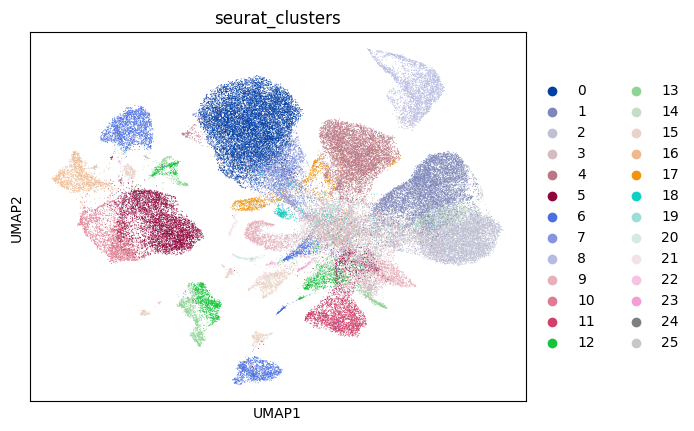

In [346]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


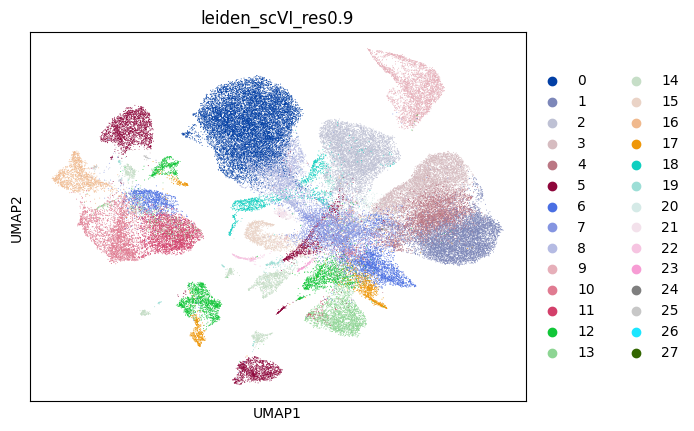

In [347]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


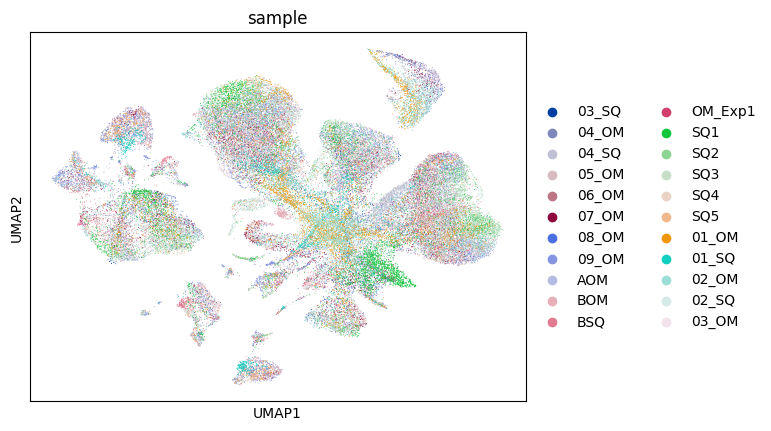

In [348]:
sc.pl.umap(train_data_2, color=['sample'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


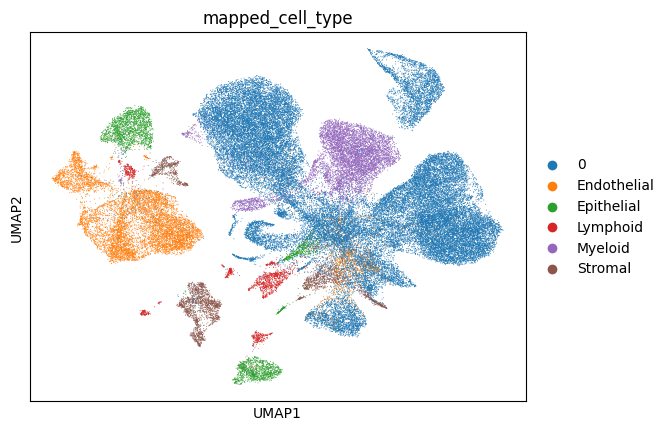

In [349]:
sc.pl.umap(train_data_2, color=['mapped_cell_type'] )

## concatenate scRNAseq & snRNAseq 

In [350]:
concat_ad = anndata.concat([train_data_2, healthy_human_lung, simulated_cell_type_ad], label="dataset", keys=["snRNAseq", "scRNAseq", "celltype_center"])
concat_ad.obsm['syy_VAE'] = np.concatenate((train_data_2.obsm['syy_VAE'], healthy_human_lung.obsm['X_uce'], simulated_cell_type_ad.obsm['X_uce']), axis=0)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [351]:
sc.pp.neighbors(concat_ad, use_rep='syy_VAE')
sc.tl.umap(concat_ad)


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


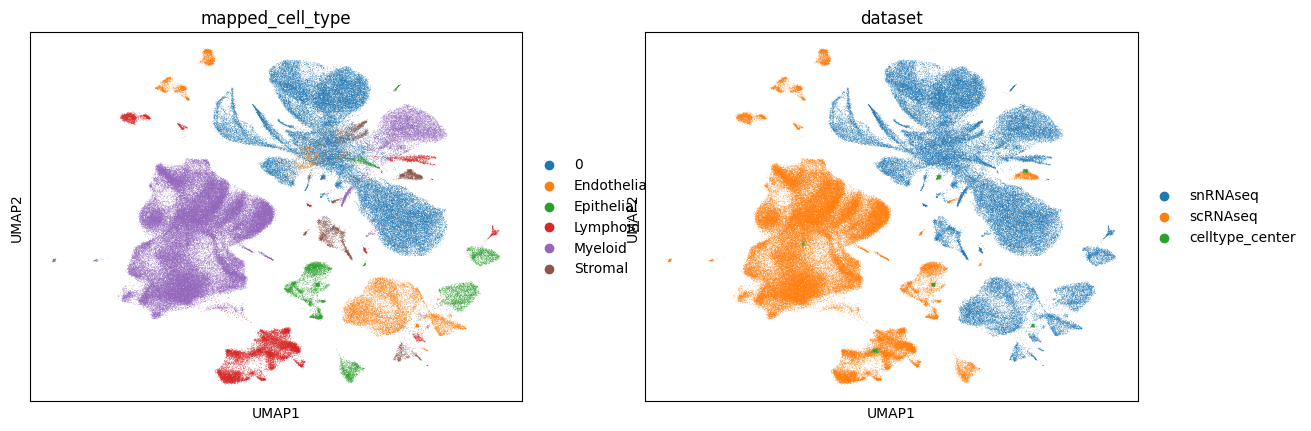

In [352]:
sc.pl.umap(concat_ad, color=['mapped_cell_type', 'dataset'] )

In [310]:
healthy_human_lung.obsm['X_uce'].min(axis=0), healthy_human_lung.obsm['X_uce'].max(axis=0)

(array([-0.10440952, -0.09936623, -0.06736035, ..., -0.10066272,
        -0.04801935, -0.07755798], dtype=float32),
 array([0.04490222, 0.03954226, 0.08342213, ..., 0.05921483, 0.06955586,
        0.08280513], dtype=float32))

In [353]:
train_data_2.obsm['syy_VAE'].min(axis=0), train_data_2.obsm['syy_VAE'].max(axis=0)

(array([-0.09040613, -0.1566072 , -0.02728696, ..., -0.14189298,
        -0.03012772, -0.08591589], dtype=float32),
 array([0.02360993, 0.01256277, 0.05442163, ..., 0.07885294, 0.04020739,
        0.04394311], dtype=float32))

In [312]:
simulated_cell_type_ad.obsm['X_uce'].min(axis=0), simulated_cell_type_ad.obsm['X_uce'].max(axis=0)

(torch.return_types.min(
 values=tensor([-0.0925, -0.0817, -0.0344,  ..., -0.0550, -0.0368, -0.0543]),
 indices=tensor([1014,  662,  811,  ...,  162,  670,  131])),
 torch.return_types.max(
 values=tensor([0.0016, 0.0135, 0.0599,  ..., 0.0324, 0.0493, 0.0519]),
 indices=tensor([1040, 1015,  856,  ...,  182,  445,   45])))

In [ ]:
sc.pl.umap(concat_ad[concat_ad.obs['dataset']=='celltype_center', ], color=['mapped_cell_type'] )

## Result is from without cell_type label.   >>>

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


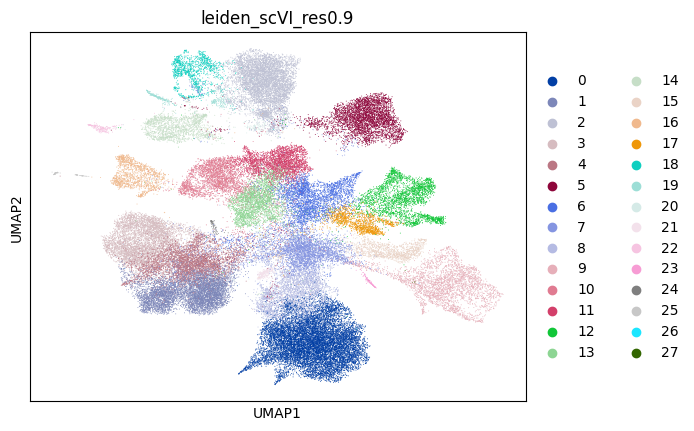

In [13]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


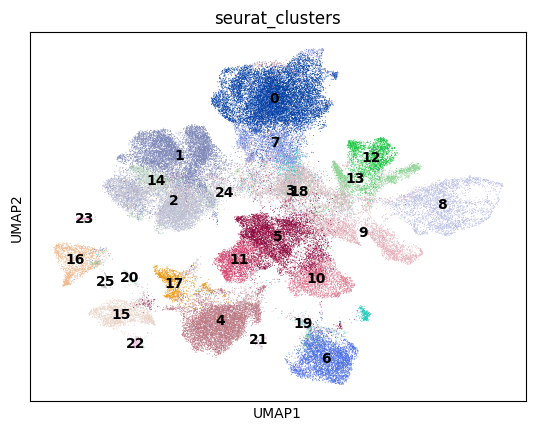

In [70]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] , legend_loc='on data')

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


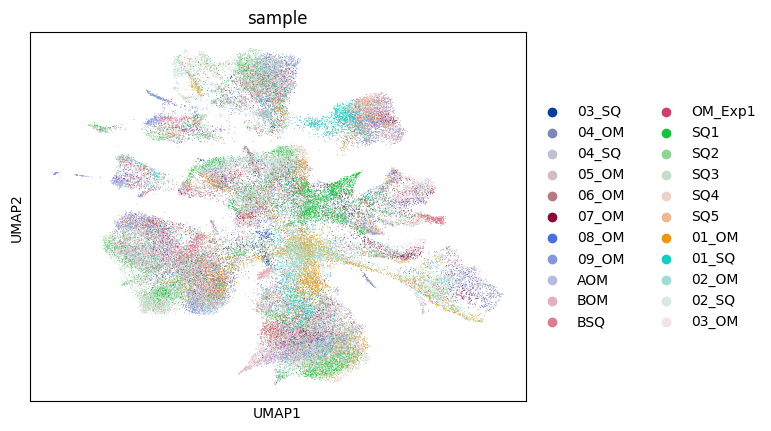

In [14]:
sc.pl.umap(train_data_2, color=['sample'] )

In [32]:
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [33]:
train_data_2.obsm['syy_VAE300epo'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE300epo')
sc.tl.umap(train_data_2)

## SCVI's results as reference

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


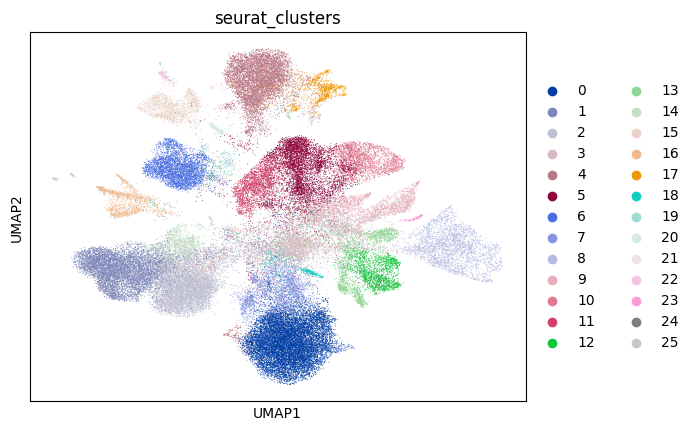

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")